# Training a DPNets-MLP on the logistic map data.

The main training problem is that the feature map gets stuck in a low-rank subspace and is unable to exit from it:
Strategies:
1. Studying & changing initializations
2. Changing the model
3. Gradient magnitudes
4. **Covariance of the intermediate activations**

I will implement the training loop in plain `torch` to study the problem.

In [1]:
import torch
from torch.utils.data import DataLoader
from kooplearn.nn.data import TrajToContextsDataset
from kooplearn.nn.functional import vamp_score, relaxed_projection_score, log_fro_metric_deformation_loss

#Plotting
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['nature', 'retro'])
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

#### Load Configs

In [28]:
import ml_confs as mlcfg
configs = mlcfg.from_file('dev_cfg.yaml', register_jax_pytree=False)

#### Unit-testing and convenience functions

In [3]:
def tensor_info(batch: torch.Tensor):
    print("------------------------------------")
    print(f"Shape: {tuple(batch.shape)}")
    print(f"Data limits : [{batch.min().item():.2e}, {batch.max().item():.2e}]")
    print(f"Variance: {batch.flatten().var().item():.2e}")

def plot_distribution_dict(distribution_dict):
    fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
    for key, value in distribution_dict.items():
        hy, hx = torch.histogram(value, density=True)
        ax.plot(hx[1:], hy, label=key)
    ax.legend(frameon=False)
    ax.set_xmargin(0)
    return fig

def effective_rank(A: torch.Tensor):
    #Roy & Vetterli, 2007
    sigma = torch.linalg.svdvals(A)
    eps = torch.finfo(sigma.dtype).eps*(min(A.shape))*10
    shannon_entr = torch.where(sigma > eps, -sigma*torch.log(sigma), torch.zeros_like(sigma))
    return torch.exp(shannon_entr.sum())

#### Data preparation

In [4]:
from kooplearn.datasets import LogisticMap
logistic = LogisticMap(N = configs.N)

sample_traj = logistic.sample(0.5, configs.num_train+configs.num_val+configs.num_test)
dataset = {
    'train': sample_traj[:configs.num_train],
    'validation': sample_traj[configs.num_train:configs.num_train+configs.num_val],
    'test': sample_traj[configs.num_train+configs.num_val:]
}

#Preparing the data
train_data = torch.from_numpy(dataset['train']).float()
val_data = torch.from_numpy(dataset['validation']).float()

train_ds = TrajToContextsDataset(train_data)
val_ds = TrajToContextsDataset(val_data)

train_dl = DataLoader(train_ds, batch_size=configs.batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

#Test shape of data
for batch in train_dl:
    tensor_info(batch)
    break

------------------------------------
Shape: (2048, 2, 1)
Data limits : [2.74e-05, 1.00e+00]
Variance: 1.06e-01


#### Defining the model

In [5]:
class SinusoidalEmbedding(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        #Assuming x is in [0, 1]
        x = 2*torch.pi*x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

class SimpleMLP(torch.nn.Module):
    def __init__(self, feature_dim: int, layer_dims: list[int], activation = torch.nn.LeakyReLU):
        super().__init__()
        self.activation = activation
        lin_dims = [2] + layer_dims + [feature_dim] #The 2 is for the sinusoidal embedding
        
        layers = []
        for layer_idx in range(len(lin_dims) - 2):
            layers.append(torch.nn.Linear(lin_dims[layer_idx], lin_dims[layer_idx+1], bias=False))
            layers.append(activation())
        layers.append(torch.nn.Linear(lin_dims[-2], lin_dims[-1], bias=True))
        self.layers = torch.nn.ModuleList(layers)
        self.sin_embedding = SinusoidalEmbedding()
    
    def forward(self, x):
        #Sinusoidal embedding
        x = self.sin_embedding(x)
        #MLP
        for layer in self.layers:
            x = layer(x)
        return x

def kaiming_init(model):
    for p in model.parameters():
        psh = p.shape
        if len(psh) == 2: #Linear layers
            _, in_shape = psh
            if in_shape == 2: #Initial layer
                torch.nn.init.uniform_(p, -1, 1)
            else:
                acname = model.activation.__name__.lower()
                if acname == 'leakyrelu':
                    acname = 'leaky_relu'
                torch.nn.init.kaiming_uniform_(p, a= 1, nonlinearity=acname)
        else: #Bias
            torch.nn.init.zeros_(p)

##### Activation shapes

SinusoidalEmbedding
------------------------------------
Shape: (2048, 2)
Data limits : [-1.00e+00, 1.00e+00]
Variance: 4.95e-01
Effective X-Cov rank: 1.51

Layer 0 - Activations
------------------------------------
Shape: (2048, 32)
Data limits : [-1.30e+00, 1.30e+00]
Variance: 3.10e-01
Effective X-Cov rank: 0.01

Layer 1 - Activations
------------------------------------
Shape: (2048, 64)
Data limits : [-1.13e+00, 1.12e+00]
Variance: 1.67e-01
Effective X-Cov rank: 0.00

Layer 2 - Activations
------------------------------------
Shape: (2048, 32)
Data limits : [-8.28e-01, 8.50e-01]
Variance: 8.72e-02
Effective X-Cov rank: 0.56

Layer 3 - Activations
------------------------------------
Shape: (2048, 4)
Data limits : [-9.29e-02, 5.36e-01]
Variance: 3.41e-02
Effective X-Cov rank: 1.46


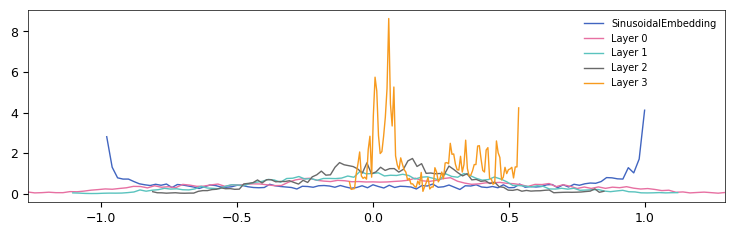

In [29]:
torch.manual_seed(configs.rng_seed)
mlp = SimpleMLP(configs.feature_dim, configs.layer_dims)
kaiming_init(mlp)

torch.manual_seed(configs.rng_seed)
mlp_lagged = SimpleMLP(configs.feature_dim, configs.layer_dims)
kaiming_init(mlp_lagged)

activations = {}
#Replicating the forward pass on a small batch
for batch in train_dl:
    x = batch[:, 0, :]
    y = batch[:, 1, :]
    print("SinusoidalEmbedding")
    x = mlp.sin_embedding(x)
    y = mlp.sin_embedding(y)
    cross_cov = (x.T @ y)/x.shape[0]
    activations['SinusoidalEmbedding'] = x.detach().flatten()
    tensor_info(x)
    print(f"Effective X-Cov rank: {effective_rank(cross_cov):.2f}")
    for i, layer in enumerate(mlp.layers):
        x = layer(x)
        y = layer(y)
        if isinstance(layer, torch.nn.Linear):
            layer_idx = (i + 1)//2
            cross_cov = (x.T @ y)/x.shape[0]
            print(f"\nLayer {layer_idx} - Activations")
            activations[f"Layer {layer_idx}"] = x.detach().flatten()
            tensor_info(x)
            print(f"Effective X-Cov rank: {effective_rank(cross_cov):.2f}")
    break  
plot_distribution_dict(activations);   

#### Setting up the training loop

In [47]:
#Fast-changing configs
lr = 1e-5
use_relaxed_loss = True
metric_deformation_loss_coefficient = 1.0

#Model init
torch.manual_seed(configs.rng_seed)
mlp = SimpleMLP(configs.feature_dim, configs.layer_dims)
kaiming_init(mlp)

torch.manual_seed(configs.rng_seed)
mlp_lagged = SimpleMLP(configs.feature_dim, configs.layer_dims)
kaiming_init(mlp_lagged)

params = list(mlp.parameters()) + list(mlp_lagged.parameters())
#Opt
torch.manual_seed(configs.rng_seed)
optimizer = torch.optim.SGD(params, lr=lr)

#The two modules should have the same initial weights
for p1, p2 in zip(mlp.parameters(), mlp_lagged.parameters()):
    assert torch.allclose(p1, p2)
#Print the number of parameters
print(f"{int(sum(p.numel() for p in mlp.parameters())/1000.0)}k parameters in each MLP")

4k parameters in each MLP


In [48]:
score = []
md = []
Xcovrank = []

grads = {}
global_step = 0
break_point = 10000
#Training Loop
for epoch in range(configs.num_epochs):
    for batch in train_dl:
        global_step += 1
        X, Y = batch[:, 0, ...], batch[:, 1, ...]
        #Encoding
        encoded_X, encoded_Y = mlp.forward(X), mlp_lagged.forward(Y)
        _norm = torch.rsqrt(torch.tensor(encoded_X.shape[0]))
        encoded_X *= _norm
        encoded_Y *= _norm
        #Compute the covariances
        cov_X = torch.mm(encoded_X.T, encoded_X)
        cov_Y = torch.mm(encoded_Y.T, encoded_Y)
        cov_XY = torch.mm(encoded_X.T, encoded_Y)
        Xcovrank.append(effective_rank(cov_XY).item())
        #Compute the losses
        if use_relaxed_loss:
            loss = -1*relaxed_projection_score(cov_X, cov_Y, cov_XY)
            score.append(-1.0*loss.item())
        else:
            loss = -1*vamp_score(cov_X, cov_Y, cov_XY, schatten_norm=2)
            score.append(-1.0*loss.item())

        if metric_deformation_loss_coefficient > 0.0:
            metric_deformation_loss = 0.5*(log_fro_metric_deformation_loss(cov_X) + log_fro_metric_deformation_loss(cov_Y))
            metric_deformation_loss = metric_deformation_loss*metric_deformation_loss_coefficient
            md.append(metric_deformation_loss.item())
            loss = loss + metric_deformation_loss
        
        #Optimization step
        optimizer.zero_grad()
        loss.backward()
        if global_step == break_point:    
            #Inspect gradients
            # for p in mlp.parameters():
            #     #Average update
            #     weights = p.data.flatten().detatch().std().item()
            #     grad = p.grad.flatten().detatch().std().item()
            #     update = lr*grad/weights
            #     tensor_info(p.grad)
            #     grads[f'layer_{p.shape[0]}_{p.shape[1]}'] = p.grad.flatten().detach()
            break
        optimizer.step()
    print(f"Epoch {epoch + 1} - Loss {-1.0*loss.item():.2f}", end='\r')
    if global_step == break_point:
        break

#Moving average
score = torch.tensor(score).view(-1, 10).mean(1)
md = torch.tensor(md).view(-1, 10).mean(1)
Xcovrank = torch.tensor(Xcovrank).view(-1, 10).mean(1)
#plot_distribution_dict(grads);

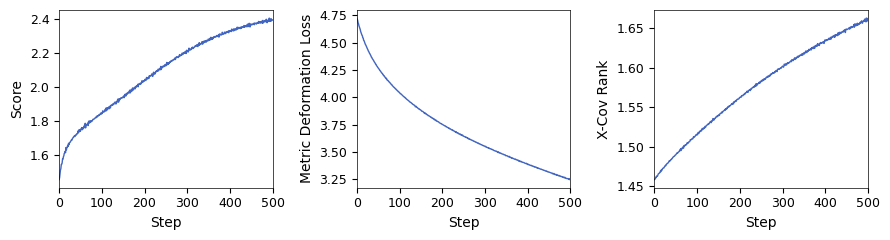

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(9, 2.5))
#Plot score, md and Xcovrank 
ax[0].plot(score)
ax[0].set_ylabel('Score')
ax[1].plot(md)
ax[1].set_ylabel('Metric Deformation Loss')
ax[2].plot(Xcovrank)
ax[2].set_ylabel('X-Cov Rank')
for a in ax:
    a.set_xlabel('Step')
    a.set_xlim(0, len(score))
fig.tight_layout()

# Gradients explode on the last layer

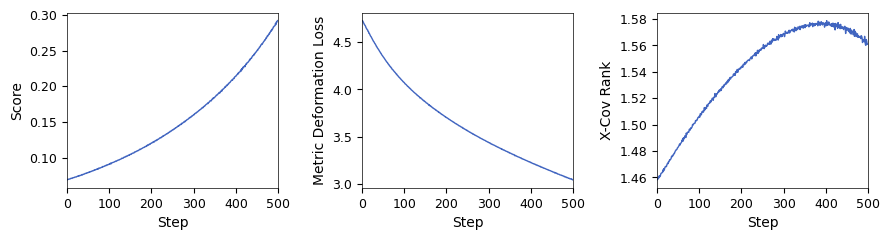

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(9, 2.5))
#Plot score, md and Xcovrank 
ax[0].plot(score)
ax[0].set_ylabel('Score')
ax[1].plot(md)
ax[1].set_ylabel('Metric Deformation Loss')
ax[2].plot(Xcovrank)
ax[2].set_ylabel('X-Cov Rank')
for a in ax:
    a.set_xlabel('Step')
    a.set_xlim(0, len(score))
fig.tight_layout()